Configuration de train_model() et predict_image() dans ce notebook

* Il faut prendre quoi comme valeur d'epsilon par defaut ?
**la meilleure combinaison de valeurs est en sortie de la fonction gridsearch_analysis (valeur par défaut changeant en fonction du set d'image)**

* train_model() prend maintenant en input: X, y, label_encoder + config.all_variables
* predict_image() prend maintenant en input un np.array

* Je ne trouve pas un model > 90% d'accuracy
**on l'a testé sur LFW; l'accuracy peut changer avec une image inconnue (d'où l'indication des améliorations futures "changer la méthode de bruit ou changer de modèle")**

* Dans la DB, les images ont 1 ou 3 channels ? (greyscale/RGB)
**originales : 3
processed/anonymisées : 1**

* J'ai ajouté une fonction resize_images à implementer dans train_model() car:
    * Taille des images variables pour chaque user
**ATTENTION : LE MODELE S'ENTRAINE SUR TOUTE LA DB. SI PLUSIEURS TAILLE D'IMAGE (DE MATRICE) SONT RENCONTRES, L'ENTRAINEMENT S'ARRETERA**
**il faut conserver les mêmes dimensions entre l'entrainement et la prédiction qu'entre chaque images**

* Verifier le ML car:
    * Nombre d'images variable en fonction des users
**AJOUT D'UN BALANCED ACCURACY UTILE MAIS OVERKILL : ON PEUT S'EN PASSER**

* Je n'ai pas utilisé les variables de **config** pour faire des fonctions plus propre. Elle pourront être récupéré plus tard juste avant l'appel des fonctions
* Ajout de show_logs car le GUI n'a pas besoin de print

In [1]:
import tensorflow as tf

import os
import io
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import src.face_recognition.ml_models as ml_models
import src.modules.data_loader as data_loader
from src.controller.ml_controller import MLController
import controller.ml_controller as ml

MODEL_SAVE_DIR = r'..\data\models\trained'
LOG_DIR = r'..\data\models\logs'
DB_PATH = r"..\data\database.db"
INPUT_SHAPE = (100, 100, 1)
WIDTH, HEIGHT = (100, 100)

In [2]:
# Aucune des variables ici n'est utilisé. Les valeurs ont été implementées en input des fonctions
# --- Chemins et Noms ---
MODEL_NAME = 'simple_cnn_lfw_anony_v1'
# --- Paramètres des Données et Prétraitement ---
COLOR_MODE = 'grayscale'
IMG_WIDTH, IMG_HEIGHT, CHANNELS = (64, 64, 1 if COLOR_MODE == 'grayscale' else 3)
# --- Paramètres de Division des Données ---
SPLIT_STRATEGY = 'stratified'
# -- Pour 'stratified' --
TEST_SPLIT_RATIO = 0.2
VALIDATION_SPLIT_RATIO = 0.15
# -- Pour 'fixed_per_subject' --
N_TRAIN_PER_SUBJECT = 16
RANDOM_STATE = 42
# ---    Paramètres du Modèle ---
MODEL_ARCHITECTURE = 'simple_cnn'
# -- Pour Transfer Learning (si MODEL_ARCHITECTURE commence par 'transfer_') --
TRANSFER_BASE_MODEL_NAME = 'MobileNetV2'
TRANSFER_FREEZE_BASE = True
# --- Paramètres d'Entraînement ---
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 10

### Data from folder (LFW dataset)

In [4]:
LFW_DATASET_PATH = r"..\data\reconstructed_pipeline"
os.makedirs(LFW_DATASET_PATH, exist_ok=True)

X, y, label_encoder = ml.data_loader.load_anonymized_images_flat(
    data_dir=LFW_DATASET_PATH,
    img_width=WIDTH,
    img_height=HEIGHT,
    color_mode='grayscale'
)

Chargement des images depuis : ..\data\reconstructed_pipeline
Format attendu : 100x100, mode: grayscale
Erreur: Aucun fichier .png trouvé dans ..\data\reconstructed_pipeline


### Data from database

In [3]:
X, y, label_encoder = MLController.get_data_from_db(DB_PATH)
print(f"(nb_image, width, height, dim) : {X.shape}")

(nb_image, width, height, dim) : (467, 100, 100, 3)


### Model

In [4]:
def prepare_data_train_model(
    X, y, label_encoder,
    input_shape=(100, 100),
    split_strategy='stratified',
    test_split_ratio=0.2,
    validation_split_ratio=0.15,
    n_train_per_subject=7,
    random_state=42,
    show_logs=False
):
    # --- -------------------------- ---
    # --- 2. Préparation des Données ---
    # --- -------------------------- ---
    if show_logs: print("\n--- Prepare data ---")

    # Reshape images (size & dim=1)
    processed_X = []
    for img in X:
        img_resized = np.array(Image.fromarray(img).resize(input_shape))
        if img_resized.ndim == 3:
            img_gray = np.dot(img_resized[..., :3], [0.2989, 0.5870, 0.1140])[..., np.newaxis]
        else:
            img_gray = img_resized[..., np.newaxis]
        processed_X.append(img_gray.astype(np.uint8))
    X = np.array(processed_X)


    num_classes = len(label_encoder.classes_)
    if show_logs: print(f"Nombre de classes détectées : {num_classes}")

    # --- ----------------------- ---
    # --- 3. Division des Données ---
    # --- ----------------------- ---
    if show_logs: print("\n--- Division des données ---")

    if split_strategy == 'stratified':
        data_splits = data_loader.split_data_stratified(
            X, y, # TODO BRUCE: data_loader.split_data_stratified()
            test_size=test_split_ratio,
            validation_size=validation_split_ratio,
            random_state=random_state
        )
        X_train = data_splits.get('X_train')
        y_train = data_splits.get('y_train')
        X_val = data_splits.get('X_val')
        y_val = data_splits.get('y_val')
        X_test = data_splits.get('X_test')
        y_test = data_splits.get('y_test')

        if X_val is None and validation_split_ratio > 0 and X_train is not None and len(X_train) > 0:
            val_ratio_from_train = validation_split_ratio / (1.0 - test_split_ratio)
            if val_ratio_from_train < 1.0:
                if show_logs: print(f"Création du set de validation depuis l'entraînement (ratio: {val_ratio_from_train:.2f})")
                X_train, X_val, y_train, y_val = train_test_split(
                    X_train, y_train,
                    test_size=val_ratio_from_train,
                    random_state=random_state,
                    stratify=y_train
                )
            else:
                print("Attention: Ratios de split incohérents, pas de données d'entraînement restantes après validation.")
    elif split_strategy == 'fixed_per_subject':
        X_train_full, X_test, y_train_full, y_test = data_loader.split_data_fixed_per_subject(
            X, y,
            n_train_per_class=n_train_per_subject,
            random_state=random_state
        )
        if validation_split_ratio > 0 and X_train_full is not None and len(X_train_full) > 0:
            if show_logs: print(f"Création du set de validation depuis l'entraînement (ratio: {validation_split_ratio})")
            X_train, X_val, y_train, y_val = train_test_split(
                X_train_full, y_train_full,
                test_size=validation_split_ratio,
                random_state=random_state,
                stratify=y_train_full
            )
        else:
            X_train, y_train = X_train_full, y_train_full
            X_val, y_val = None, None
    else:
        print(f"Erreur: Stratégie de split '{split_strategy}' non reconnue.")
        return

    if X_train is None or len(X_train) == 0:
        print("Erreur: Aucune donnée d'entraînement disponible après la division.")
        return
    if X_val is None or len(X_val) == 0:
        print("Attention: Aucune donnée de validation disponible. L'entraînement se fera sans suivi de validation.")
        validation_data = None # `fit` utilisera pas de validation
    else:
        validation_data = (X_val, y_val)
        if show_logs: print(f"Taille finale - Entraînement: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test) if X_test is not None else 0}")

    return num_classes, X_train, y_train, X_test, y_test, X_val, y_val, validation_data


In [7]:
def create_model(
    num_classes,
    input_shape,
    model_save_dir='models/trained/',
    log_dir='models/logs/',
    model_name='simple_cnn_lfw_anony_v1',
    split_strategy='stratified',
    learning_rate=0.001,
    batch_size=32,
    epochs=50,
    early_stopping_patience=10,
    transfer_base_model_name='MobileNetV2',
    transfer_freeze_base=True,
    model_architecture='simple_cnn',
    show_logs=False


    ):
    # --- --------------------------------- ---
    # --- 1. Chargement de la Configuration ---
    # --- --------------------------------- ---

    # Display model parameters
    if show_logs:
        print("Configuration personnalisée chargée :")
        print(f"  - Architecture Modèle: {model_architecture}")
        print(f"  - Nom Modèle: {model_name}")
        print(f"  - Dimensions Image: {input_shape}")
        print(f"  - Stratégie Split: {split_strategy}")
        print(f"  - Époques: {epochs}, Batch Size: {batch_size}")

    # Prepare output & log folder
    os.makedirs(model_save_dir, exist_ok=True)
    if log_dir:
        os.makedirs(log_dir, exist_ok=True)
        if show_logs: print(f"  - Dossier Logs TensorBoard: {log_dir}")

    # --- ------------------------- ---
    # --- 4. Construction du Modèle ---
    # --- ------------------------- ---
    if show_logs: print("\n--- Construction du modèle ---")
    model = None
    if model_architecture == 'simple_cnn':
        model = ml_models.build_simple_cnn(input_shape=input_shape, num_classes=num_classes)
    elif model_architecture.startswith('transfer_'):
        if show_logs: print(f"Utilisation du modèle de base: {transfer_base_model_name}, Freeze: {transfer_freeze_base}")
        model = ml_models.build_transfer_model(
            input_shape=input_shape,
            num_classes=num_classes,
            base_model_name=transfer_base_model_name,
            freeze_base=transfer_freeze_base)
    else:
        print(f"Erreur: Architecture de modèle non reconnue: {model_architecture}")
        return

    # --- ------------------------ ---
    # --- 5. Compilation du Modèle ---
    # --- ------------------------ ---
    if show_logs: print("\n--- Compilation du modèle ---")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    if show_logs:
        print("Modèle compilé avec Adam optimizer.")
        model.summary()

    # Capture model summary
    summary_io = io.StringIO()
    model.summary(print_fn=lambda x: summary_io.write(x + "\n"))
    summary_text = summary_io.getvalue()
    #summary_image = text_to_pil_image(summary_text)

    # --- ------------------------------ ---
    # --- 6. Configuration des Callbacks ---
    # --- ------------------------------ ---
    if show_logs: print("\n--- Configuration des Callbacks ---")
    callbacks = []

    model_filename = f"{model_name}.h5"
    model_filepath = os.path.join(model_save_dir, model_filename)
    if show_logs: print(f"  - ModelCheckpoint: Sauvegarde du meilleur modèle dans {model_filepath}")
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    callbacks.append(checkpoint_callback)

    if early_stopping_patience > 0:
        if show_logs: print(f"  - EarlyStopping: Activé avec patience={early_stopping_patience}")
        early_stopping_callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=early_stopping_patience,
            mode='max',
            restore_best_weights=True,
            verbose=1
        )
        callbacks.append(early_stopping_callback)
    else:
        if show_logs: print("  - EarlyStopping: Désactivé.")

    if log_dir:
        tensorboard_log_dir = os.path.join(log_dir, model_name + "_" + time.strftime("%Y%m%d-%H%M%S"))
        if show_logs: print(f"  - TensorBoard: Logs dans {tensorboard_log_dir}")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=tensorboard_log_dir,
            histogram_freq=1
        )
        callbacks.append(tensorboard_callback)
    else:
        if show_logs: print("  - TensorBoard: Désactivé.")

    csv_log_path = os.path.join(model_save_dir, f"{model_name}_training_log.csv")
    if show_logs: print(f"  - CSVLogger: Logs dans {csv_log_path}")
    csv_logger_callback = tf.keras.callbacks.CSVLogger(csv_log_path, append=False)
    callbacks.append(csv_logger_callback)

    return model, callbacks, model_filepath, summary_text





In [8]:
def _draw_accuracy_and_loss_curves(epochs_range, acc, loss, val_acc=None, val_loss=None):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc is not None:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss is not None:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    return plt


def train_model(
        model,
        X_train, y_train, X_test, y_test,
        validation_data, callbacks,
        label_encoder,
        model_filepath,

        model_save_dir='models/trained/',
        model_name='simple_cnn_lfw_anony_v1',
        batch_size=32,
        epochs=50,
        show_logs=False
):

    # --- ------------------------- ---
    # --- 7. Entraînement du Modèle ---
    # --- ------------------------- ---
    if show_logs: print("\n--- Démarrage de l'entraînement ---")
    try:
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=0
        )
        if show_logs: print("--- Entraînement terminé ---")
    except Exception as e:
        print(f"\nErreur pendant l'entraînement : {e}")
        encoder_save_path = os.path.join(model_save_dir, f"{model_name}_label_encoder.joblib")
        print("\nSauvegarde de l'encodeur de labels (même si l'entraînement a échoué)...")
        data_loader.save_label_encoder(label_encoder, encoder_save_path)
        return

    # --- -------------------- ---
    # --- 8. Post-Entraînement ---
    # --- -------------------- ---
    encoder_save_path = os.path.join(model_save_dir, f"{model_name}_label_encoder.joblib")
    if show_logs: print("\n--- Sauvegarde de l'encodeur de labels ---")
    data_loader.save_label_encoder(label_encoder, encoder_save_path)

    # Evaluation
    eval_loss, eval_acc = model.evaluate(X_test, y_test)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    if history is not None:
        if show_logs: print("\n--- Affichage des courbes d'apprentissage ---")
        try:
            acc = history.history['accuracy']
            loss = history.history['loss']
            val_acc = history.history['val_accuracy'] if validation_data else None
            val_loss = history.history['val_loss'] if validation_data else None
            epochs_range = range(len(acc))

            plt_obj = _draw_accuracy_and_loss_curves(epochs_range, acc, loss, val_acc, val_loss)
            buf = io.BytesIO()
            plt_obj.savefig(buf, format='png')
            buf.seek(0)
            image_pil = Image.open(buf)

            plot_save_path = os.path.join(model_save_dir, f"{model_name}_training_curves.pdf")
            plt.savefig(plot_save_path, format='pdf', bbox_inches='tight')
            if show_logs: print(f"Courbes sauvegardées dans : {plot_save_path}")
        except Exception as plot_e:
            print(f"Erreur lors de la génération/sauvegarde des courbes: {plot_e}")

    if show_logs:
        print(f"Le meilleur modèle devrait être sauvegardé dans : {model_filepath}")
        print(f"L'encodeur de labels est sauvegardé dans : {encoder_save_path}")

    return {
        "curves": image_pil,
        "confusion_matrix": cm,
        "classification_report": report,
        "evaluation": {
            "loss": eval_loss,
            "accuracy": eval_acc
        }
    }




--- Démarrage du Script d'Entraînement ---
***
Division des données : test_size=0.2, validation_size=0.15
Taille Test: 94 échantillons
Taille Entraînement: 303 échantillons
Taille Validation: 70 échantillons
Image size : (100, 100, 1)
***
Construction du modèle CNN simple avec input_shape=(100, 100, 1) et num_classes=43
Modèle CNN simple construit.


***

Epoch 1: val_accuracy improved from -inf to 0.01429, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 2: val_accuracy improved from 0.01429 to 0.07143, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 3: val_accuracy improved from 0.07143 to 0.08571, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 4: val_accuracy improved from 0.08571 to 0.11429, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 5: val_accuracy did not improve from 0.11429

Epoch 6: val_accuracy did not improve from 0.11429

Epoch 7: val_accuracy did not improve from 0.11429

Epoch 8: val_accuracy did not improve from 0.11429

Epoch 9: val_accuracy did not improve from 0.11429

Epoch 10: val_accuracy did not improve from 0.11429

Epoch 11: val_accuracy did not improve from 0.11429

Epoch 12: val_accuracy did not improve from 0.11429

Epoch 13: val_accuracy improved from 0.11429 to 0.12857, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 14: val_accuracy did not improve from 0.12857

Epoch 15: val_accuracy did not improve from 0.12857

Epoch 16: val_accuracy improved from 0.12857 to 0.20000, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 17: val_accuracy improved from 0.20000 to 0.21429, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 18: val_accuracy improved from 0.21429 to 0.24286, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 19: val_accuracy improved from 0.24286 to 0.25714, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 20: val_accuracy improved from 0.25714 to 0.30000, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 21: val_accuracy did not improve from 0.30000

Epoch 22: val_accuracy improved from 0.30000 to 0.31429, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 23: val_accuracy did not improve from 0.31429

Epoch 24: val_accuracy did not improve from 0.31429

Epoch 25: val_accuracy improved from 0.31429 to 0.37143, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 26: val_accuracy did not improve from 0.37143

Epoch 27: val_accuracy did not improve from 0.37143

Epoch 28: val_accuracy did not improve from 0.37143

Epoch 29: val_accuracy did not improve from 0.37143

Epoch 30: val_accuracy did not improve from 0.37143

Epoch 31: val_accuracy improved from 0.37143 to 0.38571, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 32: val_accuracy did not improve from 0.38571

Epoch 33: val_accuracy did not improve from 0.38571

Epoch 34: val_accuracy did not improve from 0.38571

Epoch 35: val_accuracy did not improve from 0.38571

Epoch 36: val_accuracy did not improve from 0.38571

Epoch 37: val_accuracy did not improve from 0.38571

Epoch 38: val_accuracy did not improve from 0.38571

Epoch 39: val_accuracy improved from 0.38571 to 0.42857, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 40: val_accuracy improved from 0.42857 to 0.47143, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 41: val_accuracy improved from 0.47143 to 0.50000, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 42: val_accuracy did not improve from 0.50000

Epoch 43: val_accuracy did not improve from 0.50000

Epoch 44: val_accuracy did not improve from 0.50000

Epoch 45: val_accuracy did not improve from 0.50000

Epoch 46: val_accuracy did not improve from 0.50000

Epoch 47: val_accuracy did not improve from 0.50000

Epoch 48: val_accuracy did not improve from 0.50000

Epoch 49: val_accuracy improved from 0.50000 to 0.51429, saving model to models/trained/simple_cnn_lfw_anony_v1.h5



Epoch 50: val_accuracy did not improve from 0.51429
Restoring model weights from the end of the best epoch: 49.
LabelEncoder sauvegardé dans : models/trained/simple_cnn_lfw_anony_v1_label_encoder.joblib
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4500 - loss: 2.2880
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


D:\myDocs\Apprentissage\Isep\Year_3\Brno-Privacy_Preserving_Face_Recognition_Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\myDocs\Apprentissage\Isep\Year_3\Brno-Privacy_Preserving_Face_Recognition_Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\myDocs\Apprentissage\Isep\Year_3\Brno-Privacy_Preserving_Face_Recognition_Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels w

***
--- Script d'Entraînement Terminé en 153.38 secondes ---


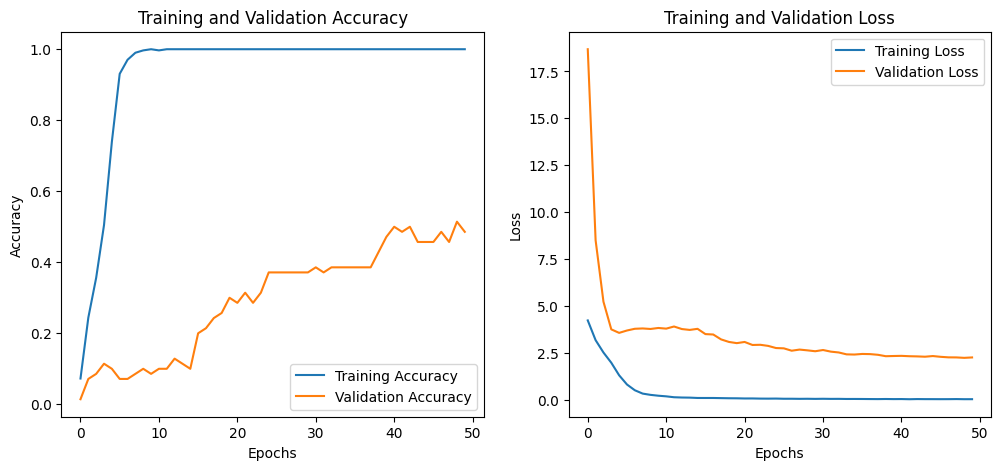

In [9]:
# Start timer
print("--- Démarrage du Script d'Entraînement ---")
start_time = time.time()
print('***')

# Transforme data
res = prepare_data_train_model(X, y, label_encoder, input_shape=(WIDTH, HEIGHT))
num_classes, X_train, y_train, X_test, y_test, X_val, y_val, validation_data = res
print(f"Image size : {X_train.shape[1:]}")
print('***')

# Create model
res = create_model(num_classes, INPUT_SHAPE)
model, callbacks, model_filepath, summary_text = res
print('***')

# Train Model
res = train_model(model, X_train, y_train, X_test, y_test, validation_data, callbacks, label_encoder, model_filepath)
print('***')

# END
end_time = time.time()
duration = end_time - start_time
print(f"--- Script d'Entraînement Terminé en {duration:.2f} secondes ---")

In [12]:
print(summary_text)

Model: "simple_cnn"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 100, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼─────────────────────

# Test

In [10]:
# Image to predict
index = 30

img_to_predict = X[index]
true_result = y[index]
print(img_to_predict.shape)

# Make a prediction
prediction = ml.predict_image(img_to_predict, model_save_dir=MODEL_SAVE_DIR)

# Result
print(f"prediction: {prediction}")
print(f"true_result: {true_result}")
print(f"The model is correct: {prediction==true_result}")

LabelEncoder chargé depuis : ..\data\models\trained\simple_cnn_lfw_anony_v1_label_encoder.joblib


D:\myDocs\Apprentissage\Isep\Year_3\Brno-Privacy_Preserving_Face_Recognition_Project\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(1, 100, 100, 3))
  warnings.warn(msg)


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv1_1" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (1, 100, 100, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(1, 100, 100, 3), dtype=float32)
  • training=False
  • mask=None